In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    action = np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    
    #if word == 'aargh':
    #    print(f'recons', action, history, guesses)
    return action

def construct_action_vectors_global(arg): #guesses, history, start_idx, end_idx):
    st = time.time()
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    ret = np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    #print(f'construct_actions_global took {time.time() - st}')
    return ret

           
def construct_action_vectors(guesses, history, df):
        return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iterrows()])

    
NUM_PROCESSES = mp.cpu_count() - 1
def construct_action_vectors_mp(guesses, history, df):
        grp_lst_args = []
        grp_guesses = [guesses] * NUM_PROCESSES
        grp_history = [history] * NUM_PROCESSES
        
        chunk_size = int(len(df) / NUM_PROCESSES) + 1
        start_offsets = list(range(0, len(df), chunk_size))
        end_offsets = start_offsets[1:] + [len(df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        pool = mp.Pool(processes=NUM_PROCESSES)
        results = pool.map(construct_action_vectors_global, grp_lst_args)
        pool.close()
        pool.join()
        return np.concatenate(results)
    
    
def construct_state_vector(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))


    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [1]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [5]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x))

In [6]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(inputs, actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x))

In [4]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        action_tactics = [env.find_words_matching_current_history, env.find_words_with_highest_freq_score, env.find_words_with_most_new_letters]
        self.actions = permutations(action_tactics)
        
        self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            df = tactic(df)
        return df.sample() # then pick a random word from what is left
    
    

In [7]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5

n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [8]:
def optimize_model(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
    reward_batch = np.stack([tr.reward for tr in transitions])
    
    
    # calculate gradient
    probs = policy(state_batch)
    sampler = Categorical(probs)
    log_probs = -sampler.log_prob(action_batch)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    pseudo_loss = torch.sum(log_probs * reward_batch) # loss that when differentiated with autograd gives the gradient of J(θ)
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()
    
    return pseudo_loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [9]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_vector(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_input_features, len(policy.actions)).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = PolicyNetNN(n_input_features, len(policy.actions)).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(env.word_from_index(action_idx))
            print(f'------guess {t} {action_idx} {guesses[-1]} {chosen_word}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_vector(guesses, history)
                
            print(f'reward {reward} done {done} ')
            reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action_idx, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for tr in episode_memory:
                    memory.push(tr[0], tr[1], episode_reward)
                    episode_reward -= tr[2]
                
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params []
=========================episode 0 lorry======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 12418
word at 12418 is entry
------guess 0 12418 entry [1.         1.         0.57437359 0.         0.        ]-------
reward 4.0 done False 
startword analysis tensor([0.4000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 276 from 53 conformant words
word at 276 is ambry
------guess 1 276 ambry [1.         0.6        0.47486872 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11140 from 23 conformant words

reward 1.0 done False 
startword analysis tensor([0.4000, 0.2000, 2.4000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12088 from 2 conformant words
word at 12088 is issue
------guess 4 12088 issue [1.         0.2        0.78805701 0.33333333 0.        ]-------
reward 5.0 done True 
episode 4 finished.  reward [10.]  eps 0.0  gamma 0.10416586470347178  steps 23  memory 18
=========================episode 5 money======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 5328
word at 5328 is lours
------guess 0 5328 lours [1.         1.         0.63444861 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8000, 0.

reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 3808 from 182 conformant words
word at 3808 is gurus
------guess 1 3808 gurus [1.         0.6        0.5248012  0.33333333 1.        ]-------
reward 4.0 done False 
startword analysis tensor([0.4000, 0.4000, 0.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11063 from 1 conformant words
word at 11063 is augur
------guess 2 11063 augur [1.         0.2        0.50454614 0.33333333 0.        ]-------
reward 4.0 done True 
episode 9 finished.  reward [10.]  eps 0.0  gamma 0.1974812020375215  steps 45  memory 42
=========================episode 10 heron======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11085 from 742 conformant words
word at 11085 is buggy
------guess 1 11085 buggy [1.         0.6        0.28507127 0.33333333 0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 2482 from 326 conformant words
word at 2482 is doyly
------guess 2 2482 doyly [1.         0.6        0.4324081  0.33333333 1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.8000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 4454 from 20 conformant words
word at 4454 is j

reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 340 from 222 conformant words
word at 340 is anomy
------guess 1 340 anomy [1.         0.6        0.52303076 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.2000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 7055 from 31 conformant words
word at 7055 is prams
------guess 2 7055 prams [1.        0.6       0.6243961 0.        1.       ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10839 from 1 conformant words
word at 10839 is champ
------

reward 6.0 done False 
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12072 from 3 conformant words
word at 12072 is bingo
------guess 2 12072 bingo [1.         0.2        0.43270818 0.         0.        ]-------
reward 0 done False 
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11680 from 2 conformant words
word at 11680 is dingo
------guess 3 11680 dingo [1.         0.2        0.45749437 0.         0.        ]-------
reward 2.0 done True 
episode 23 finished.  reward [10.]  eps 0.0  gamma 0.42305018961951335  steps 111  memory 107
=========================episode 24 grace======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9522 from 37 conformant words
word at 9522 is trier
------guess 1 9522 trier [1.         0.4        0.66112528 0.33333333 1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 4273 from 4 conformant words
word at 4273 is icier
------guess 2 4273 icier [1.         0.2        0.61113278 0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.6000, 0.0000, 1.4000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11375 from 3 conformant words
word at 11375 is plier
--

reward 0 done False 
startword analysis tensor([0.8000, 0.0000, 1.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12358 from 5 conformant words
word at 12358 is bound
------guess 5 12358 bound [1.         0.2        0.41953488 0.         0.        ]-------
reward 0 done True 
episode 32 finished.  reward [8.]  eps 0.0  gamma 0.5323335729900908  steps 153  memory 147
=========================episode 33 lorry======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 5541
word at 5541 is masus
------guess 0 5541 masus [1.         0.8        0.7143886  0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858

reward 3.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 1527 from 13 conformant words
word at 1527 is chars
------guess 2 1527 chars [1.         0.4        0.61818455 0.         1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.8000, 0.0000, 1.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 1523 from 6 conformant words
word at 1523 is chara
------guess 3 1523 chara [1.         0.         0.59792948 0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.8000, 0.0000, 1.4000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12466 from 5 conformant words
word at 12466 is chart
--

reward 2.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11956 from 2 conformant words
word at 11956 is rocky
------guess 3 11956 rocky [1.         0.4        0.42619655 0.         0.        ]-------
reward 4.0 done True 
episode 41 finished.  reward [10.]  eps 0.0  gamma 0.622807646436843  steps 196  memory 192
=========================episode 42 hater======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 8116
word at 8116 is seric
------guess 0 8116 seric [1.         1.         0.69833458 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 

reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9665 from 24 conformant words
word at 9665 is typal
------guess 1 9665 typal [1.         0.6        0.50259565 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.4000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9019 from 4 conformant words
word at 9019 is tabla
------guess 2 9019 tabla [1.         0.2        0.60834209 0.33333333 1.        ]-------
reward 4.0 done False 
startword analysis tensor([0.8000, 0.0000, 1.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12216 from 1 conformant words
word at 12216 is table


reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 1236 from 53 conformant words
word at 1236 is buffa
------guess 2 1236 buffa [1.         0.4        0.37083271 0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.2000, 0.2000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10686 from 30 conformant words
word at 10686 is batty
------guess 3 10686 batty [1.         0.4        0.48855214 0.33333333 0.        ]-------
reward 3.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.8000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 687 from 6 conformant words
word at 687 is barmy
--

reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 7082 from 2618 conformant words
word at 7082 is prial
------guess 1 7082 prial [1.         0.8        0.57905476 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.2000, 1.4000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 102 from 504 conformant words
word at 102 is adust
------guess 2 102 adust [1.         0.8        0.62757689 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.2000, 2.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12681 from 59 conformant words
word at 12681 is heave
--

reward 0 done False 
startword analysis tensor([0.6000, 0.0000, 2.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12724 from 1 conformant words
word at 12724 is boney
------guess 5 12724 boney [1.         0.4        0.53272318 0.         0.        ]-------
reward 4.0 done True 
episode 60 finished.  reward [10.]  eps 0.0  gamma 0.7582859831029636  steps 285  memory 279
=========================episode 61 bluer======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 3776
word at 3776 is gugas
------guess 0 3776 gugas [1.         0.8        0.55375844 0.33333333 1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0

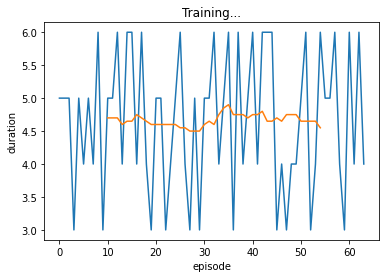

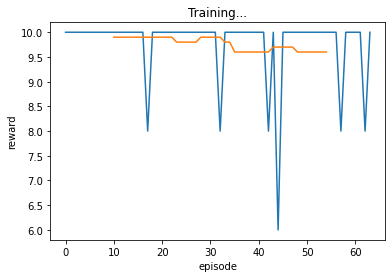

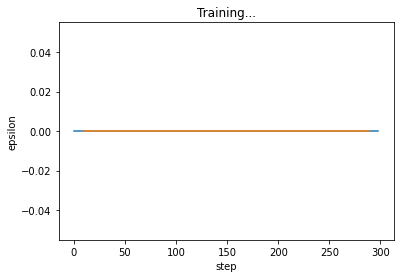

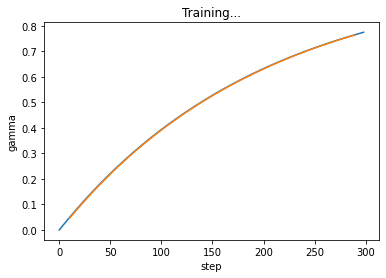

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword=None, target_list_only=False),
    num_episodes=64
    ))


pn params []
=========================episode 0 lorry======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 12418
word at 12418 is entry
------guess 0 12418 entry [1.         1.         0.57437359 0.         0.        ]-------
reward 4.0 done False 
startword analysis tensor([0.4000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10716 from 19 conformant words
word at 10716 is ivory
------guess 1 10716 ivory [1.         0.6        0.45380345 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12806 from 4 conforman

reward 0 done False 
startword analysis tensor([0.4000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11002 from 1 conformant words
word at 11002 is money
------guess 3 11002 money [1.        0.6       0.5431958 0.        0.       ]-------
reward 6.0 done True 
episode 5 finished.  reward [10.]  eps 0.0  gamma 0.09967547741373439  steps 22  memory 18
=========================episode 6 detox======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 6534
word at 6534 is padre
------guess 0 6534 padre [1.         1.         0.63861965 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0

reward 4.0 done False 
startword analysis tensor([0.2000, 0.4000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10808 from 6 conformant words
word at 10808 is heron
------guess 2 10808 heron [1.         0.4        0.59924981 0.         0.        ]-------
reward 6.0 done True 
episode 10 finished.  reward [10.]  eps 0.0  gamma 0.18941575402981292  steps 43  memory 40
=========================episode 11 using======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 633
word at 633 is baken
------guess 0 633 baken [1.         1.         0.56222056 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6

reward 5.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11425 from 3 conformant words
word at 11425 is spiny
------guess 3 11425 spiny [1.         0.4        0.52420105 0.         0.        ]-------
reward 4.0 done True 
episode 15 finished.  reward [10.]  eps 0.0  gamma 0.2702111257309432  steps 64  memory 60
=========================episode 16 hydro======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 9402
word at 9402 is tolus
------guess 0 9402 tolus [1.         1.         0.60855214 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8000, 0

reward 1.0 done False 
startword analysis tensor([0.2000, 0.0000, 1.4000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12746 from 30 conformant words
word at 12746 is biddy
------guess 2 12746 biddy [1.         0.6        0.37107277 0.33333333 0.        ]-------
reward 0 done False 
startword analysis tensor([0.2000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12177 from 6 conformant words
word at 12177 is sixth
------guess 3 12177 sixth [1.         0.8        0.47312828 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.2000, 2.6000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12113 from 1 conformant words
word at 12113 is hi

reward 3.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11776 from 25 conformant words
word at 11776 is emcee
------guess 1 11776 emcee [1.         0.4        0.71987997 0.66666667 0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10914 from 4 conformant words
word at 10914 is rupee
------guess 2 10914 rupee [1.         0.6        0.66052513 0.33333333 0.        ]-------
reward 6.0 done True 
episode 26 finished.  reward [10.]  eps 0.0  gamma 0.41433070985520626  steps 108  memory 105
=========================episode 27 gouge======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000

reward 3.0 done False 
startword analysis tensor([0.6000, 0.4000, 1.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12289 from 1 conformant words
word at 12289 is abode
------guess 3 12289 abode [1.         0.         0.63525881 0.         0.        ]-------
reward 2.0 done True 
episode 31 finished.  reward [10.]  eps 0.0  gamma 0.47006451168243146  steps 128  memory 124
=========================episode 32 wound======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 3498
word at 3498 is gighe
------guess 0 3498 gighe [1.         0.8        0.46418605 0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 

reward 3.0 done False 
startword analysis tensor([0.6000, 0.2000, 1.8000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.2500, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11740 from 1 conformant words
word at 11740 is creep
------guess 4 11740 creep [1.         0.         0.64603151 0.33333333 0.        ]-------
reward 3.0 done True 
episode 36 finished.  reward [10.]  eps 0.0  gamma 0.5228860844789656  steps 149  memory 144
=========================episode 37 chard======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 7514
word at 7514 is renga
------guess 0 7514 renga [1.         1.         0.64234059 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000,

reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12929 from 875 conformant words
word at 12929 is rodeo
------guess 1 12929 rodeo [1.         0.8        0.66463616 0.33333333 0.        ]-------
reward 4.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11956 from 3 conformant words
word at 11956 is rocky
------guess 2 11956 rocky [1.         0.6        0.42619655 0.         0.        ]-------
reward 6.0 done True 
episode 41 finished.  reward [10.]  eps 0.0  gamma 0.5725850680512733  steps 171  memory 168
=========================episode 42 hater======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11251 from 368 conformant words
word at 11251 is covet
------guess 1 11251 covet [1.         1.         0.51363841 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 1.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11977 from 14 conformant words
word at 11977 is ditty
------guess 2 11977 ditty [1.         0.6        0.4463916  0.33333333 0.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.2000, 2.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10772 from 2 conformant words
word at 10772 is th

reward 0 done False 
startword analysis tensor([0.6000, 0.0000, 1.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10716 from 1 conformant words
word at 10716 is ivory
------guess 3 10716 ivory [1.         0.4        0.45380345 0.         0.        ]-------
reward 4.0 done True 
episode 52 finished.  reward [10.]  eps 0.0  gamma 0.6535441896699425  steps 213  memory 209
=========================episode 53 buxom======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 1386
word at 1386 is camps
------guess 0 1386 camps [1.         1.         0.56048012 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0

reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11373 from 5 conformant words
word at 11373 is risky
------guess 2 11373 risky [1.         0.6        0.54496624 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.4000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.6000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12711 from 1 conformant words
word at 12711 is rinse
------guess 3 12711 rinse [1.         0.4        0.72606152 0.         0.        ]-------
reward 5.0 done True 
episode 58 finished.  reward [10.]  eps 0.0  gamma 0.689633058734515  steps 235  memory 231
=========================episode 59 denim======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

reward 2.0 done False 
startword analysis tensor([0.0000, 0.6000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12214 from 3 conformant words
word at 12214 is humus
------guess 3 12214 humus [1.         0.2        0.4628057  0.33333333 0.        ]-------
reward 7.0 done True 
episode 63 finished.  reward [10.]  eps 0.0  gamma 0.7191683782216203  steps 255  memory 251
Complete


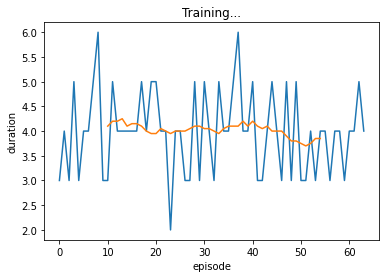

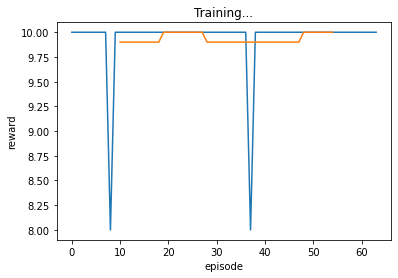

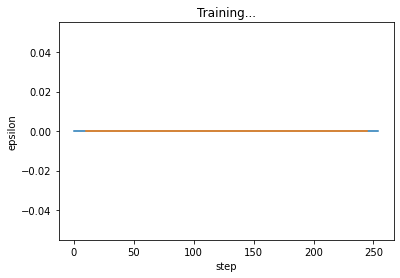

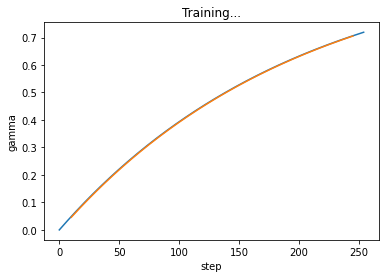

In [14]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword=None, target_list_only=True),
    num_episodes=64
    ))

pn params []
=========================episode 0 lorry======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12443 from 18 conformant words
word at 12443 is color
------guess 1 12443 color [1.         0.4        0.55312828 0.33333333 0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.4000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12806 from 2 conforma

reward 4.0 done False 
startword analysis tensor([0.6000, 0.2000, 0.6000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12055 from 1 conformant words
word at 12055 is detox
------guess 2 12055 detox [1.         0.2        0.51420855 0.         0.        ]-------
reward 3.0 done True 
episode 6 finished.  reward [10.]  eps 0.0  gamma 0.09967547741373439  steps 22  memory 19
=========================episode 7 visit======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000

reward 1.0 done False 
startword analysis tensor([0.0000, 0.4000, 2.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10837 from 1 conformant words
word at 10837 is using
------guess 3 10837 using [1.         0.6        0.52606152 0.         0.        ]-------
reward 8.0 done True 
episode 11 finished.  reward [10.]  eps 0.0  gamma 0.18941575402981292  steps 43  memory 39
=========================episode 12 piece======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.40

reward 4.0 done False 
startword analysis tensor([0.4000, 0.0000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10901 from 42 conformant words
word at 10901 is shake
------guess 1 10901 shake [1.         0.6        0.67762941 0.         0.        ]-------
reward 3.0 done False 
startword analysis tensor([0.6000, 0.2000, 0.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11014 from 2 conformant words
word at 11014 is phase
------guess 2 11014 phase [1.         0.2        0.69305326 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11309 from 1 conformant words
word at 11309 is 

reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11119 from 66 conformant words
word at 11119 is whoop
------guess 1 11119 whoop [1.         0.6        0.41092273 0.33333333 0.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.2000, 1.6000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12606 from 16 conformant words
word at 12606 is nylon
------guess 2 12606 nylon [1.         0.6        0.47372843 0.33333333 0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.4000, 2.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12072 from 2 conformant words
word at 12072 is b

reward 3.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11415 from 3 conformant words
word at 11415 is flier
------guess 2 11415 flier [1.         0.4        0.57209302 0.         0.        ]-------
reward 5.0 done True 
episode 28 finished.  reward [10.]  eps 0.0  gamma 0.4113950303216448  steps 107  memory 104
=========================episode 29 flesh======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4

reward 3.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12806 from 4 conformant words
word at 12806 is lorry
------guess 2 12806 lorry [1.         0.2        0.54610653 0.33333333 0.        ]-------
reward 4.0 done True 
episode 33 finished.  reward [10.]  eps 0.0  gamma 0.47006451168243146  steps 128  memory 125
=========================episode 34 trait======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 4.0 done False 
startword analysis tensor([0.2000, 0.4000, 0.4000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.

reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12235 from 195 conformant words
word at 12235 is billy
------guess 1 12235 billy [1.         0.8        0.42616654 0.33333333 0.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 1.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12215 from 16 conformant words
word at 12215 is shush
------guess 2 12215 shush [1.         0.6        0.58097524 0.66666667 0.        ]-------
reward 3.0 done False 
startword analysis tensor([0.0000, 0.6000, 2.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12214 from 1 conformant words
word at 12214 is hu

reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11310 from 21 conformant words
word at 11310 is reply
------guess 1 11310 reply [1.         0.6        0.54865716 0.         0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12039 from 7 conformant words
word at 12039 is recur
------guess 2 12039 recur [1.         0.4        0.58565641 0.33333333 0.        ]-------
reward 0 done False 
startword analysis tensor([0.4000, 0.0000, 1.8000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10934 from 3 conformant words
word at 10934 is re

reward 1.0 done False 
startword analysis tensor([0.2000, 0.2000, 2.4000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12180 from 1 conformant words
word at 12180 is elegy
------guess 4 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 6.0 done True 
episode 50 finished.  reward [10.]  eps 0.0  gamma 0.6151878554470214  steps 192  memory 187
=========================episode 51 baggy======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4

reward 2.0 done False 
startword analysis tensor([0.8000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12832 from 1 conformant words
word at 12832 is madly
------guess 4 12832 madly [1.         0.2        0.47603901 0.         0.        ]-------
reward 2.0 done True 
episode 55 finished.  reward [10.]  eps 0.0  gamma 0.6535441896699425  steps 213  memory 208
=========================episode 56 beach======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4

reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11315 from 102 conformant words
word at 11315 is diner
------guess 1 11315 diner [1.         0.6        0.59966992 0.         0.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12095 from 22 conformant words
word at 12095 is upper
------guess 2 12095 upper [1.         0.4        0.5212003  0.33333333 0.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.4000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11751 from 4 conformant words
word at 11751 i

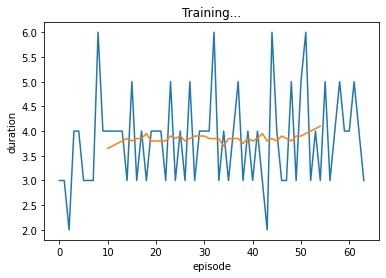

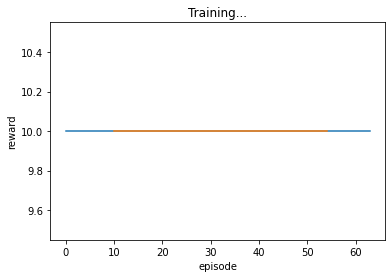

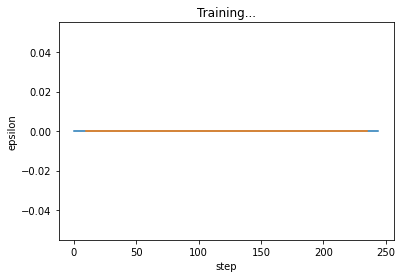

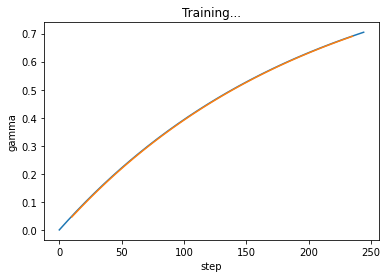

In [15]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword='roate', target_list_only=True),
    num_episodes=64
    ))


pn params []
=========================episode 0 lorry======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8616 from 138 conformant words
word at 8616 is sorus
------guess 1 8616 sorus [1.         0.4        0.73329332 0.33333333 1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11756 from 36 conforman

reward 0 done False 
startword analysis tensor([0.2000, 0.2000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8087 from 10 conformant words
word at 8087 is semie
------guess 3 8087 semie [1.         0.4        0.77191298 0.33333333 1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.4000, 2.4000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12088 from 1 conformant words
word at 12088 is issue
------guess 4 12088 issue [1.         0.2        0.78805701 0.33333333 0.        ]-------
reward 6.0 done True 
episode 4 finished.  reward [10.]  eps 0.0  gamma 0.10863385609316867  steps 24  memory 19
=========================episode 5 money======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10610 from 383 conformant words
word at 10610 is ziram
------guess 1 10610 ziram [1.         0.6        0.48963241 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.0000, 0.4000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 723 from 32 conformant words
word at 723 is baurs
------guess 2 723 baurs [1.         0.6        0.62868717 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.6000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11063 from 1 conformant words
word at 11063 is augur


reward 0 done False 
startword analysis tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10597 from 920 conformant words
word at 10597 is zimbi
------guess 1 10597 zimbi [1.         0.8        0.34673668 0.33333333 1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 1.8000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11760 from 161 conformant words
word at 11760 is finch
------guess 2 11760 finch [1.         0.8        0.34850713 0.         0.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 2.4000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12234 from 5 conformant words
word at 12234 is

reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10606 from 324 conformant words
word at 10606 is zinke
------guess 1 10606 zinke [1.         0.8        0.45947487 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.2000, 0.0000, 1.6000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8025 from 114 conformant words
word at 8025 is scuse
------guess 2 8025 scuse [1.         0.6        0.73611403 0.33333333 1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 2.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 5077 from 5 conformant words
word at 5077 is lees

reward 1.0 done False 
startword analysis tensor([0.0000, 0.4000, 1.4000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 4799 from 22 conformant words
word at 4799 is klong
------guess 2 4799 klong [1.         0.6        0.41740435 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.0000, 0.6000, 1.8000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 6832 from 6 conformant words
word at 6832 is pingo
------guess 3 6832 pingo [1.         0.4        0.44447112 0.         1.        ]-------
reward 5.0 done False 
startword analysis tensor([0.8000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12072 from 3 conformant words
word at 12072 is bingo


reward 2.0 done False 
startword analysis tensor([0.6000, 0.0000, 2.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10790 from 1 conformant words
word at 10790 is gouge
------guess 5 10790 gouge [1.         0.2        0.50709677 0.33333333 0.        ]-------
reward 4.0 done True 
episode 27 finished.  reward [10.]  eps 0.0  gamma 0.4857264722933681  steps 134  memory 128
=========================episode 28 flier======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4

reward 2.0 done False 
startword analysis tensor([0.2000, 0.0000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12912 from 626 conformant words
word at 12912 is going
------guess 1 12912 going [1.         0.6        0.4332183  0.33333333 0.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.0000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10637 from 38 conformant words
word at 10637 is zoons
------guess 2 10637 zoons [1.         0.4        0.56795199 0.33333333 1.        ]-------
reward 0 done False 
startword analysis tensor([0.4000, 0.0000, 1.8000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 6255 from 15 conformant words
word at 6255 is n

reward 2.0 done False 
startword analysis tensor([0.2000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11740 from 20 conformant words
word at 11740 is creep
------guess 2 11740 creep [1.         0.4        0.64603151 0.33333333 0.        ]-------
reward 6.0 done True 
episode 36 finished.  reward [10.]  eps 0.0  gamma 0.5893442472476544  steps 179  memory 176
=========================episode 37 chard======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.8000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.73647412 0.         1.        ]-------
reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.

reward 2.0 done False 
startword analysis tensor([0.6000, 0.0000, 1.6000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 7649 from 3 conformant words
word at 7649 is roguy
------guess 3 7649 roguy [1.         0.4        0.44486122 0.         1.        ]-------
reward 0 done False 
startword analysis tensor([0.6000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12005 from 2 conformant words
word at 12005 is rowdy
------guess 4 12005 rowdy [1.         0.4        0.42496624 0.         0.        ]-------
reward 0 done False 
startword analysis tensor([0.6000, 0.0000, 2.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11956 from 1 conformant words
word at 11956 is rocky
--

reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11264 from 122 conformant words
word at 11264 is risen
------guess 1 11264 risen [1.         0.6        0.72606152 0.         0.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10934 from 3 conformant words
word at 10934 is renew
------guess 2 10934 renew [1.         0.2        0.64435109 0.33333333 0.        ]-------
reward 5.0 done True 
episode 45 finished.  reward [10.]  eps 0.0  gamma 0.670441038924811  steps 223  memory 220
=========================episode 46 table======================
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,

reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8965 from 1054 conformant words
word at 8965 is sweys
------guess 1 8965 sweys [1.         0.6        0.69332333 0.33333333 1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.2000, 0.2000, 1.2000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 3551 from 13 conformant words
word at 3551 is gleby
------guess 2 3551 gleby [1.         0.6        0.46145536 0.         1.        ]-------
reward 4.0 done False 
startword analysis tensor([0.6000, 0.2000, 1.4000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12180 from 1 conformant words
word at 12180 is ele

reward 1.0 done False 
startword analysis tensor([0.0000, 0.2000, 0.8000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 2902 from 1135 conformant words
word at 2902 is fanks
------guess 1 2902 fanks [1.         0.8        0.54694674 0.         1.        ]-------
reward 1.0 done False 
startword analysis tensor([0.2000, 0.0000, 1.6000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11488 from 172 conformant words
word at 11488 is gayly
------guess 2 11488 gayly [1.         0.6        0.45470368 0.33333333 0.        ]-------
reward 4.0 done False 
startword analysis tensor([0.6000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.3333, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10077 from 10 conformant words
word at 10077 i

reward 3.0 done False 
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 4193 from 264 conformant words
word at 4193 is hoven
------guess 1 4193 hoven [1.         0.6        0.49530383 0.         1.        ]-------
reward 2.0 done False 
startword analysis tensor([0.4000, 0.2000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12471 from 26 conformant words
word at 12471 is nosey
------guess 2 12471 nosey [1.         0.4        0.68390098 0.         0.        ]-------
reward 2.0 done False 
startword analysis tensor([0.6000, 0.2000, 1.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.2000, 0.6858, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12724 from 4 conformant words
word at 12724 is b

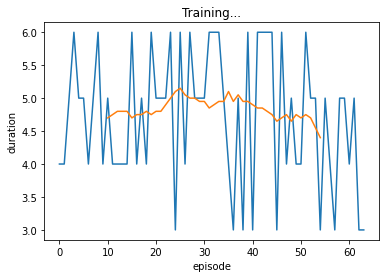

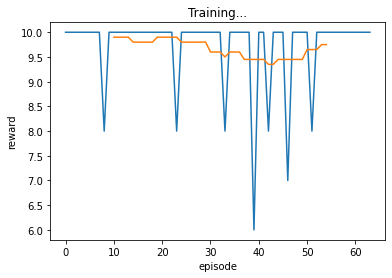

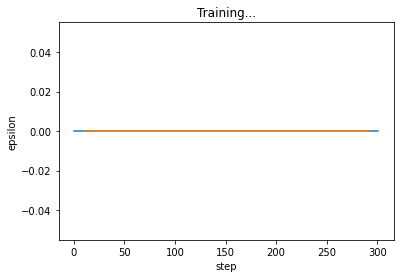

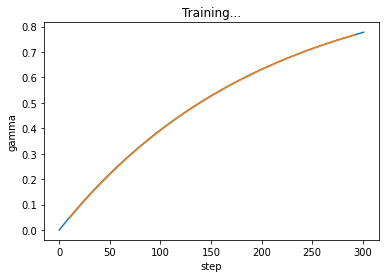

In [16]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword='roate', target_list_only=False),
    num_episodes=64
    ))



pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 don

reward 2.0 done False 
------guess 1 11995 blimp [1.         0.6        0.38265566 0.         0.        ]-------
reward 2.0 done False 
------guess 2 10839 champ [1.         0.6        0.41329332 0.         0.        ]-------
reward 6.0 done True 
episode 18 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 99  memory 96
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.]), array([2.]), array([6.])]
=========================episode 19 geese======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 1 12097 wight [1.         1.         0.34499625 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12846 clang [1.         0.8        0.47966992 0.         0.        ]-------
reward 0 done False 
------guess 3 11169 grove [1.       0.8      0.528012 0.       0.      ]-------
reward 3.0 done False 
------guess 4 10754 forge [0.75       0.2        0.54064516 0.

reward 3.0 done False 
------guess 1 10683 abase [1.         0.4        0.80822206 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 11785 crest [1.        0.6       0.6844111 0.        0.       ]-------
reward 1.0 done False 
------guess 3 11955 poesy [1.         0.6        0.65590398 0.         0.        ]-------
reward 0 done False 
------guess 4 10710 flesh [1.         0.6        0.58733683 0.         0.        ]-------
reward 6.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 148  memory 143
original rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
hybrid rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
=========================episode 30 dryer======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 1.0 done False 
------guess 1 12514 rarer [1.         0.4        0.75396849 0.66666667 0.        ]-------
reward 4.0 done False 
------g

reward 1.0 done False 
------guess 1 12458 pasta [1.         0.6        0.71894974 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 11497 kiosk [1.         0.6        0.53629407 0.33333333 0.        ]-------
reward 0 done False 
------guess 3 12590 mucus [1.         0.6        0.47084771 0.33333333 0.        ]-------
reward 6.0 done False 
------guess 4 12214 humus [1.         0.2        0.4628057  0.33333333 0.        ]-------
reward 3.0 done True 
episode 39 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 196  memory 191
original rewards [array([1.]), array([0]), array([0]), array([6.]), array([3.])]
hybrid rewards [array([1.]), array([0]), array([0]), array([6.]), array([3.])]
=========================episode 40 mauve======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 1 11855 aware [1.         0.6        0.71534884 0.33333333 0.        ]-------
reward 1.0 done False 
--

reward 1.0 done False 
------guess 1 10951 natal [1.         0.6        0.64810203 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 2 11033 gloat [1.         0.4        0.56228057 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11880 bloat [1.         0.2        0.56177044 0.         0.        ]-------
reward 2.0 done True 
episode 49 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 244  memory 240
original rewards [array([1.]), array([3.]), array([4.]), array([2.])]
hybrid rewards [array([1.]), array([3.]), array([4.]), array([2.])]
=========================episode 50 elegy======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 1 11616 elect [1.         0.6        0.66070518 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 2 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 4.0 done True 
episode 50 finished. 

reward 1.0 done False 
------guess 1 11495 title [1.         0.6        0.6116129  0.33333333 0.        ]-------
reward 0 done False 
------guess 2 12772 gooey [1.         0.6        0.57782446 0.33333333 0.        ]-------
reward 5.0 done False 
------guess 3 11002 money [1.        0.4       0.5431958 0.        0.       ]-------
reward 2.0 done False 
------guess 4 11274 honey [1.         0.2        0.53671418 0.         0.        ]-------
reward 0 done False 
------guess 5 12724 boney [1.         0.2        0.53272318 0.         0.        ]-------
reward 2.0 done True 
episode 60 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 294  memory 288
original rewards [array([1.]), array([0]), array([5.]), array([2.]), array([0]), array([2.])]
hybrid rewards [array([1.]), array([0]), array([5.]), array([2.]), array([0]), array([2.])]
=========================episode 61 bluer======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
rewa

reward 5.0 done False 
------guess 1 12151 afire [1.         0.4        0.65068267 0.         0.        ]-------
reward 0 done False 
------guess 2 10727 agree [1.         0.2        0.75366842 0.33333333 0.        ]-------
reward 5.0 done True 
episode 70 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 338  memory 335
original rewards [array([5.]), array([0]), array([5.])]
hybrid rewards [array([5.]), array([0]), array([5.])]
=========================episode 71 alley======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 11086 alien [1.         0.6        0.68219055 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11566 alley [1.         0.2        0.64420105 0.33333333 0.        ]-------
reward 4.0 done True 
episode 71 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 341  memory 338
original rewards [array([3.]), array([3.]), array([4.])]
hybrid rewards [array([3.]), array

reward 1.0 done False 
------guess 2 12270 blare [1.        0.2       0.6544036 0.        0.       ]-------
reward 3.0 done False 
------guess 3 12654 flare [1.         0.2        0.63903976 0.         0.        ]-------
reward 2.0 done True 
episode 82 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 383  memory 379
original rewards [array([4.]), array([1.]), array([3.]), array([2.])]
hybrid rewards [array([4.]), array([1.]), array([3.]), array([2.])]
=========================episode 83 tilde======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 11753 utile [1.         0.8        0.58808702 0.         0.        ]-------
reward 3.0 done False 
------guess 2 10818 tilde [1.         0.2        0.58634659 0.         0.        ]-------
reward 5.0 done True 
episode 83 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 386  memory 383
original rewards [array([2.]), array([3.]), array([5.])]
hybrid re

reward 1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10881 could [1.         0.6        0.44414104 0.         0.        ]-------
reward 6.0 done False 
------guess 3 11703 would [1.         0.2        0.41446362 0.         0.        ]-------
reward 2.0 done True 
episode 94 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 429  memory 425
original rewards [array([1.]), array([1.]), array([6.]), array([2.])]
hybrid rewards [array([1.]), array([1.]), array([6.]), array([2.])]
loss 0.8902727365493774
=========================episode 95 bylaw======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11859 bylaw [1.         0.6        0.42313578 0.         0.        ]-------
reward 7.0 done True 
ep

reward 3.0 done False 
------guess 1 12441 tried [1.         0.6        0.60996249 0.         0.        ]-------
reward 4.0 done False 
------guess 2 12115 drier [1.         0.         0.63585896 0.33333333 0.        ]-------
reward 3.0 done True 
episode 106 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 472  memory 469
original rewards [array([3.]), array([4.]), array([3.])]
hybrid rewards [array([3.]), array([4.]), array([3.])]
=========================episode 107 punch======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12840 punch [1.         0.6        0.33818455 0.         0.        ]-------
reward 8.0 done True 
episode 107 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 475  memory 472
original rewards [array([0]), array([2.]), array([8.])]
hybrid rewards [array([0]), ar

reward 2.0 done False 
------guess 1 10752 islet [1.         0.6        0.71273818 0.         0.        ]-------
reward 0 done False 
------guess 2 10764 spend [1.         0.6        0.62268567 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11768 speck [1.         0.4        0.56651163 0.         0.        ]-------
reward 4.0 done True 
episode 119 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 519  memory 515
original rewards [array([2.]), array([0]), array([4.]), array([4.])]
hybrid rewards [array([2.]), array([0]), array([4.]), array([4.])]
loss 0.8818058371543884
=========================episode 120 chest======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 3.0 done False 
------guess 2 10938 chest [1.         0.2        0.61245311 0.         0.        ]-------
reward 4.0 done True 
episode 1

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12818 timid [1.         0.4        0.45737434 0.33333333 0.        ]-------
reward 7.0 done True 
episode 132 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 564  memory 561
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
=========================episode 133 vegan======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12739 pecan [1.         0.4        0.58967742 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward 2.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11115 fungi [1.         0.4        0.35951988 0.         0.        ]-------
reward 7.0 done True 
episode 144 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 611  memory 608
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
loss 0.8570311069488525
=========================episode 145 fiber======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 4.0 done False 
------guess 2 11858 timer [1.         0.4        0.59564891 0.         0.        ]-------
reward 0 done False 
------guess 3 12024 cider [1.         0.4        0.57194299 0.         0.        ]-------
reward 0 done False 
------guess 4 11434 fiber [1.         

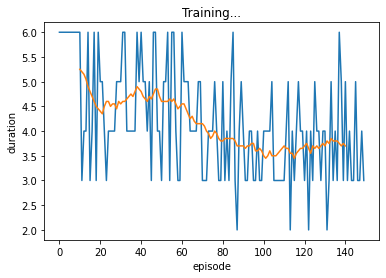

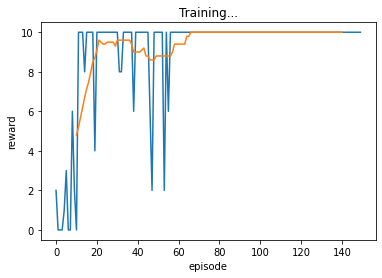

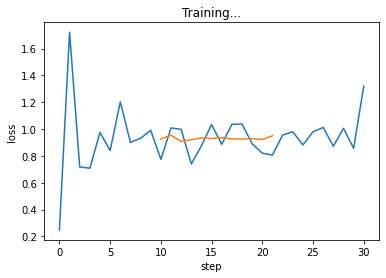

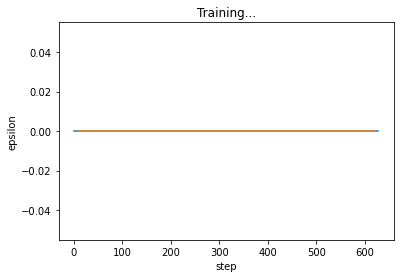

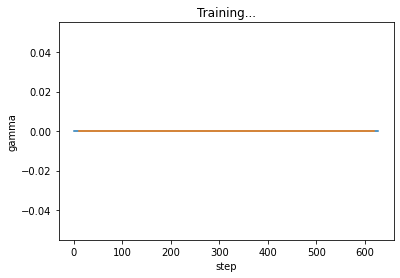

In [17]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 don

reward 4.0 done False 
------guess 1 12743 guise [1.         0.6        0.63738935 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12731 geese [1.         0.         0.84906227 0.66666667 0.        ]-------
reward 4.0 done True 
episode 19 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 99  memory 96
original rewards [array([4.]), array([2.]), array([4.])]
hybrid rewards [array([4.]), array([2.]), array([4.])]
=========================episode 20 hippo======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12113 hippo [1.         0.2        0.41995499 0.33333333 0.        ]-------
reward 6.0 done True 
episode 20 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 102  memory 99
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([1.]), arra

reward 3.0 done False 
------guess 1 10683 abase [1.         0.4        0.80822206 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 11785 crest [1.        0.6       0.6844111 0.        0.       ]-------
reward 1.0 done False 
------guess 3 11955 poesy [1.         0.6        0.65590398 0.         0.        ]-------
reward 0 done False 
------guess 4 10710 flesh [1.         0.6        0.58733683 0.         0.        ]-------
reward 6.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 150  memory 145
original rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
hybrid rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
=========================episode 30 dryer======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 1.0 done False 
------guess 1 12514 rarer [1.         0.4        0.75396849 0.66666667 0.        ]-------
reward 4.0 done False 
------g

reward 1.0 done False 
------guess 1 12458 pasta [1.         0.6        0.71894974 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 12322 lousy [1.         0.8        0.57191298 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12758 virus [1.         0.6        0.53374344 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12590 mucus [1.         0.4        0.47084771 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 5 12214 humus [1.         0.2        0.4628057  0.33333333 0.        ]-------
reward 3.0 done True 
episode 39 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 200  memory 194
original rewards [array([1.]), array([0]), array([1.]), array([2.]), array([3.]), array([3.])]
hybrid rewards [array([1.]), array([0]), array([1.]), array([2.]), array([3.]), array([3.])]
=========================episode 40 mauve======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]---

reward 3.0 done False 
------guess 2 11775 mafia [0.5        0.6        0.56504126 0.33333333 0.        ]-------
reward 0 done False 
------guess 3 11105 octal [1.         0.2        0.57380345 0.         0.        ]-------
reward 1.0 done False 
------guess 4 11033 gloat [1.         0.2        0.56228057 0.         0.        ]-------
reward 3.0 done False 
------guess 5 11880 bloat [1.         0.2        0.56177044 0.         0.        ]-------
reward 2.0 done True 
episode 49 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 246  memory 240
original rewards [array([1.]), array([3.]), array([0]), array([1.]), array([3.]), array([2.])]
hybrid rewards [array([1.]), array([3.]), array([0]), array([1.]), array([3.]), array([2.])]
loss 0.7065801024436951
=========================episode 50 elegy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.    

reward 4.0 done False 
------guess 3 11274 honey [1.         0.2        0.53671418 0.         0.        ]-------
reward 0 done False 
------guess 4 12724 boney [1.         0.2        0.53272318 0.         0.        ]-------
reward 2.0 done True 
episode 60 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 290  memory 285
original rewards [array([2.]), array([2.]), array([4.]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([2.]), array([4.]), array([0]), array([2.])]
=========================episode 61 bluer======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 3.0 done False 
------guess 2 10894 ulcer [1.         0.4        0.56204051 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11508 bluer [1.        0.2       0.5500075 0.        0.       ]-------
reward 3.0 done True 
episode 61 fin

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11307 ninja [1.         0.4        0.47843961 0.33333333 0.        ]-------
reward 7.0 done True 
episode 72 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 334  memory 331
original rewards [array([1.]), array([2.]), array([7.])]
hybrid rewards [array([1.]), array([2.]), array([7.])]
=========================episode 73 knife======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 11753 utile [1.         0.8        0.58808702 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12421 chide [1.       0.6      0.499985 0.       0.      ]-------
reward 0 done False 
------guess 3 11712 knife [1.         0.6        0.47990998 0.         0.        ]-------
reward 6.0 done True 
episode 73 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 33

reward 4.0 done False 
------guess 1 12740 droit [1.         0.6        0.54322581 0.         0.        ]-------
reward 0 done False 
------guess 2 12816 crony [1.        0.6       0.4696174 0.        0.       ]-------
reward 1.0 done False 
------guess 3 11981 grown [1.         0.4        0.42703676 0.         0.        ]-------
reward 3.0 done False 
------guess 4 12880 brown [1.         0.2        0.42652663 0.         0.        ]-------
reward 2.0 done True 
episode 84 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 383  memory 378
original rewards [array([4.]), array([0]), array([1.]), array([3.]), array([2.])]
hybrid rewards [array([4.]), array([0]), array([1.]), array([3.]), array([2.])]
=========================episode 85 batty======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 1.0 done False 
------gu

reward 2.0 done False 
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12489 hyena [1.         0.4        0.58328582 0.         0.        ]-------
reward 6.0 done True 
episode 96 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 428  memory 425
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.]), array([2.]), array([6.])]
=========================episode 97 apply======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12799 antic [1.         0.8        0.54085521 0.         0.        ]-------
reward 0 done False 
------guess 2 11004 album [1.         0.8        0.46436609 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11850 apply [1.         0.4        0.46430608 0.33333333 0.        ]-------
reward 7.0 done True 
episode 97 finished.  reward [10.]  eps 0.0  gamma 0.0

reward 2.0 done False 
------guess 1 12237 clout [1.         0.8        0.46940735 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12839 thong [1.         0.6        0.42277569 0.         0.        ]-------
reward 7.0 done True 
episode 108 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 473  memory 470
original rewards [array([2.]), array([1.]), array([7.])]
hybrid rewards [array([2.]), array([1.]), array([7.])]
=========================episode 109 edict======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11462 edict [1.         0.4        0.54604651 0.         0.        ]-------
reward 6.0 done True 
episode 109 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 476  memory 473
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([1.])

reward 3.0 done False 
------guess 1 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 3.0 done False 
------guess 2 10938 chest [1.         0.2        0.61245311 0.         0.        ]-------
reward 4.0 done True 
episode 120 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 518  memory 515
original rewards [array([3.]), array([3.]), array([4.])]
hybrid rewards [array([3.]), array([3.]), array([4.])]
=========================episode 121 whiny======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11476 dying [1.         0.6        0.38655664 0.         0.        ]-------
reward 3.0 done False 
------guess 3 12189 whiny [1.        0.4       0.3476069 0.        0.       ]-------
reward 5.0 done True 
episode 121 finished.  reward [10.]  eps 0.0  gamma 0.0  steps

reward 1.0 done False 
------guess 3 12818 timid [1.         0.4        0.45737434 0.33333333 0.        ]-------
reward 6.0 done True 
episode 132 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 562  memory 558
original rewards [array([0]), array([3.]), array([1.]), array([6.])]
hybrid rewards [array([0]), array([3.]), array([1.]), array([6.])]
loss 1.135887622833252
=========================episode 133 vegan======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12739 pecan [1.         0.4        0.58967742 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward 2.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0.        0.       ]-------
reward 2.0 done True 
episode 133 f

reward 0 done False 
------guess 3 11017 gloom [1.         0.4        0.47612903 0.33333333 0.        ]-------
reward 6.0 done True 
episode 142 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 609  memory 605
original rewards [array([2.]), array([2.]), array([0]), array([6.])]
hybrid rewards [array([2.]), array([2.]), array([0]), array([6.])]
=========================episode 143 girly======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 11748 lurid [1.         0.8        0.48768192 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 6.0 done True 
episode 143 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 612  memory 609
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([1.]), array([3.]), array([6.])]
=========================episode 144 fungi=====================

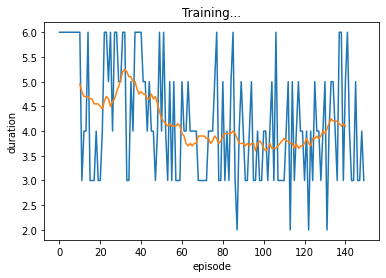

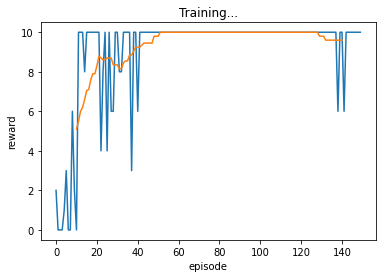

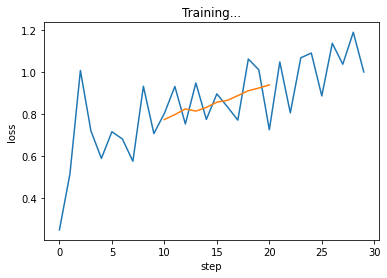

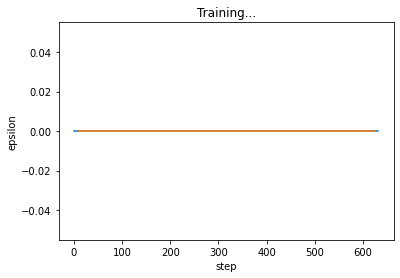

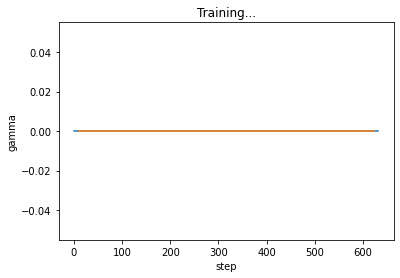

In [18]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.03)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 don

reward 4.0 done False 
------guess 1 12743 guise [1.         0.6        0.63738935 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12901 pulse [0.5        0.4        0.63699925 0.         0.        ]-------
reward 0 done False 
------guess 3 11309 chase [0.33333333 0.4        0.69332333 0.         0.        ]-------
reward 0 done False 
------guess 4 12646 noise [0.5        0.2        0.73446362 0.         0.        ]-------
reward 0 done False 
------guess 5 12901 pulse [0.6        0.         0.63699925 0.         0.        ]-------
reward 0 done True 
episode 19 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 103  memory 97
original rewards [array([4.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([4.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
loss 0.8026826977729797
=========================episode 20 hippo======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.      

reward 3.0 done False 
------guess 1 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 1.0 done False 
------guess 2 10710 flesh [1.         0.4        0.58733683 0.         0.        ]-------
reward 6.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 149  memory 146
original rewards [array([3.]), array([1.]), array([6.])]
hybrid rewards [array([3.]), array([1.]), array([6.])]
=========================episode 30 dryer======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 12441 tried [1.         0.6        0.60996249 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11806 dryer [1.         0.2        0.58529632 0.33333333 0.        ]-------
reward 5.0 done True 
episode 30 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 152  memory 149
original rewards [array([3.]), array([2.]), array([5.])]
hybrid rewards [array([3.]), array(

reward 3.0 done False 
------guess 1 11898 plate [1.         0.6        0.64027007 0.         0.        ]-------
reward 0 done False 
------guess 2 12238 dance [1.         0.6        0.60270068 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12199 maize [1.         0.6        0.56477119 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12505 maybe [1.        0.4       0.5500075 0.        0.       ]-------
reward 0 done False 
------guess 5 12702 mauve [1.         0.4        0.53512378 0.         0.        ]-------
reward 4.0 done True 
episode 40 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 199  memory 193
original rewards [array([3.]), array([0]), array([1.]), array([2.]), array([0]), array([4.])]
hybrid rewards [array([3.]), array([0]), array([1.]), array([2.]), array([0]), array([4.])]
loss 0.747243344783783
=========================episode 41 rocky======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 

reward 0 done False 
------guess 1 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 2 11372 freer [1.         0.4        0.68282071 0.66666667 0.        ]-------
reward 1.0 done False 
------guess 3 11616 elect [1.         0.6        0.66070518 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 4 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 4.0 done True 
episode 50 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 248  memory 243
original rewards [array([0]), array([2.]), array([1.]), array([3.]), array([4.])]
hybrid rewards [array([0]), array([2.]), array([1.]), array([3.]), array([4.])]
=========================episode 51 baggy======================
------guess 0 12794 mamma [1.         0.4        0.53737434 1.         0.        ]-------
reward 2.0 done False 
------guess 1 11735 sassy [1.         0.4        0.8419805  0.66666667 0.        ]-------
reward 2.0 done False

reward 2.0 done False 
------guess 1 12485 tenor [1.         0.6        0.64531133 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11845 idler [1.         0.6        0.61224306 0.         0.        ]-------
reward 2.0 done False 
------guess 3 10894 ulcer [1.         0.4        0.56204051 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11508 bluer [1.        0.2       0.5500075 0.        0.       ]-------
reward 3.0 done True 
episode 61 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 294  memory 289
original rewards [array([2.]), array([1.]), array([2.]), array([2.]), array([3.])]
hybrid rewards [array([2.]), array([1.]), array([2.]), array([2.]), array([3.])]
loss 0.8414064645767212
=========================episode 62 funky======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
rewar

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 0 done False 
------guess 2 12897 mangy [1.        0.8       0.4391898 0.        0.       ]-------
reward 2.0 done False 
------guess 3 12860 fauna [1.         0.4        0.55687922 0.33333333 0.        ]-------
reward 7.0 done True 
episode 74 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 339  memory 335
original rewards [array([1.]), array([0]), array([2.]), array([7.])]
hybrid rewards [array([1.]), array([0]), array([2.]), array([7.])]
=========================episode 75 dairy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 10895 ultra [1.         0.6        0.57989497 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12343 cairn [1.         0.6        0.56675169 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11687 dairy [1.     

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12052 haunt [1.         0.6        0.49536384 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12300 tacky [0.66666667 0.6        0.44687172 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11962 patsy [0.75       0.2        0.60144036 0.         0.        ]-------
reward 1.0 done False 
------guess 5 11507 matey [0.8        0.2        0.60006002 0.         0.        ]-------
reward 0 done True 
episode 85 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 387  memory 381
original rewards [array([1.]), array([1.]), array([1.]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([1.]), array([1.]), array([1.]), array([2.]), array([1.]), array([0])]
loss 0.8985291123390198
=========================episode 86 boost======================
------guess 0 11909 arose [1.        1.        0.8375994 0.   

reward 2.0 done False 
------guess 1 12799 antic [1.         0.8        0.54085521 0.         0.        ]-------
reward 0 done False 
------guess 2 11004 album [1.         0.8        0.46436609 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11850 apply [1.         0.4        0.46430608 0.33333333 0.        ]-------
reward 7.0 done True 
episode 97 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 429  memory 425
original rewards [array([2.]), array([0]), array([1.]), array([7.])]
hybrid rewards [array([2.]), array([0]), array([1.]), array([7.])]
=========================episode 98 after======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 12165 alter [1.         0.4        0.70445611 0.         0.        ]-------
reward 4.0 done False 
------guess 2 12031 after [1.         0.2        0.63675919 0.         0.        ]-------
reward 2.0 done True 
episode 98 finished.  reward [

reward 4.0 done False 
------guess 1 11182 aloud [1.         0.6        0.56303076 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11901 afoul [1.         0.2        0.52288072 0.         0.        ]-------
reward 3.0 done True 
episode 110 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 473  memory 470
original rewards [array([4.]), array([3.]), array([3.])]
hybrid rewards [array([4.]), array([3.]), array([3.])]
=========================episode 111 quote======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 12742 clone [1.         0.6        0.58367592 0.         0.        ]-------
reward 0 done False 
------guess 2 10739 biome [1.        0.6       0.5539985 0.        0.       ]-------
reward 0 done False 
------guess 3 12640 quote [1.         0.6        0.51066767 0.         0.        ]-------
reward 6.0 done True 
episode 111 finished.  reward [10.]  eps 0.0  gamma 0.0  st

reward 4.0 done False 
------guess 1 12091 urine [1.         0.6        0.60141035 0.         0.        ]-------
reward 6.0 done True 
episode 122 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 517  memory 515
original rewards [array([4.]), array([6.])]
hybrid rewards [array([4.]), array([6.])]
=========================episode 123 bland======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12647 gland [1.         0.4        0.49242311 0.         0.        ]-------
reward 5.0 done False 
------guess 3 11060 bland [1.         0.2        0.49191298 0.         0.        ]-------
reward 2.0 done True 
episode 123 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 521  memory 517
original rewards [array([1.]), array([2.]), array([5.]), array([2.])]
hybrid rewards [array([1.]), array([2.])

reward 1.0 done False 
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward 2.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0.        0.       ]-------
reward 2.0 done True 
episode 133 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 564  memory 559
original rewards [array([3.]), array([2.]), array([1.]), array([2.]), array([2.])]
hybrid rewards [array([3.]), array([2.]), array([1.]), array([2.]), array([2.])]
=========================episode 134 nasal======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 1 12771 nasal [1.         0.4        0.74922731 0.33333333 0.        ]-------
reward 8.0 done True 
episode 134 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 566  memory 564
original rewards [array([2.]), array([8.])]
hybrid rewards [array([2.]), array([8.])]
=========================episode 135 stick======================

reward 2.0 done False 
------guess 1 11365 mania [1.         0.6        0.62016504 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 2 12410 ninny [1.         0.2        0.4407802  0.66666667 0.        ]-------
reward 0 done False 
------guess 3 11115 fungi [1.         0.6        0.35951988 0.         0.        ]-------
reward 7.0 done True 
episode 144 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 610  memory 606
original rewards [array([2.]), array([1.]), array([0]), array([7.])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([7.])]
loss 1.083293080329895
=========================episode 145 fiber======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 1.0 done False 
------guess 1 12514 rarer [1.         0.4        0.75396849 0.66666667 0.        ]-------
reward 3.0 done False 
------guess 2 11666 otter [1.         0.4        0.6556039  0.33333333 0.        ]-------
reward 0 done False 
-

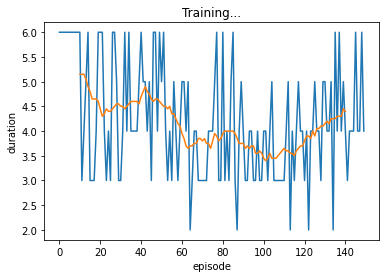

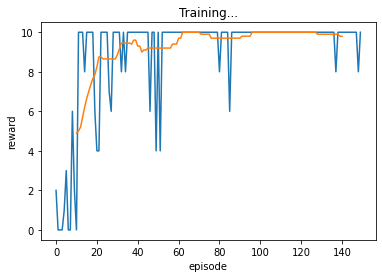

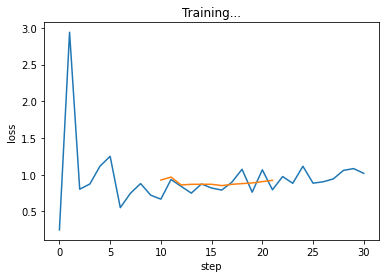

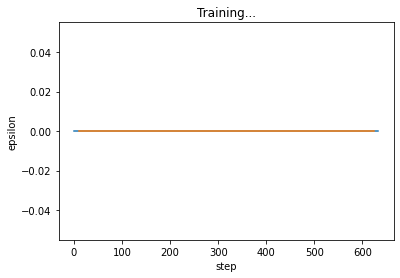

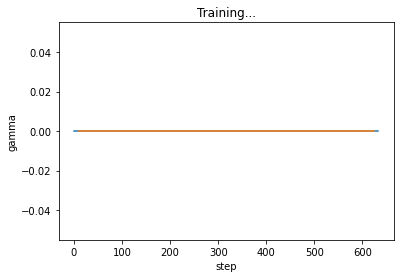

In [19]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.1)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.3  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([1.4]), array([0.4]), array([0]), array([1.4]), array([0.4]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0

reward 2.0 done False 
------guess 1 11995 blimp [1.         0.6        0.38265566 0.         0.        ]-------
reward 2.0 done False 
------guess 2 10839 champ [1.         0.6        0.41329332 0.         0.        ]-------
reward 6.0 done True 
episode 18 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 99  memory 96
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.9]), array([2.9]), array([6.9])]
=========================episode 19 geese======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 1 12097 wight [1.         1.         0.34499625 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12846 clang [1.         0.8        0.47966992 0.         0.        ]-------
reward 0 done False 
------guess 3 11169 grove [1.       0.8      0.528012 0.       0.      ]-------
reward 3.0 done False 
------guess 4 10754 forge [0.75       0.2        0.54064516

reward 3.0 done False 
------guess 1 12009 posse [1.         0.4        0.79366842 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 1.0 done False 
------guess 3 10710 flesh [1.         0.4        0.58733683 0.         0.        ]-------
reward 6.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 146  memory 142
original rewards [array([3.]), array([0]), array([1.]), array([6.])]
hybrid rewards [array([3.6]), array([0]), array([1.6]), array([6.6])]
=========================episode 30 dryer======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 1 12278 order [1.         0.4        0.65623406 0.33333333 0.        ]-------
reward 4.0 done False 
------guess 2 12115 drier [1.         0.2        0.63585896 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 3 11806 dryer 

reward 0 done False 
------guess 2 6468 ottos [1.         0.4        0.66409602 0.66666667 1.        ]-------
reward 0 done False 
------guess 3 5164 lills [1.         0.4        0.61626407 0.66666667 1.        ]-------
reward 0 done False 
------guess 4 8930 susus [0.75       0.2        0.75069767 1.         1.        ]-------
reward 4.0 done False 
------guess 5 2801 esses [0.6        0.         0.99981995 1.         1.        ]-------
reward 0 done True 
episode 39 finished.  reward [6.]  eps 0.0  gamma 0.3  steps 194  memory 188
original rewards [array([2.]), array([0]), array([0]), array([0]), array([4.]), array([0])]
hybrid rewards [array([1.4]), array([0]), array([0]), array([0]), array([3.4]), array([0])]
=========================episode 40 mauve======================
------guess 0 2801 esses [1.         0.4        0.99981995 1.         1.        ]-------
reward 1.0 done False 
------guess 1 401 arear [1.         0.4        0.80894224 0.66666667 1.        ]-------
reward 1.0 do

reward 1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12736 leech [1.         0.4        0.61464366 0.33333333 0.        ]-------
reward 2.0 done False 
------guess 3 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 6.0 done True 
episode 50 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 239  memory 235
original rewards [array([1.]), array([1.]), array([2.]), array([6.])]
hybrid rewards [array([1.6]), array([1.6]), array([2.6]), array([6.6])]
=========================episode 51 baggy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 10951 natal [1.         0.6        0.64810203 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 2 11458 magic [1.         0.8        0.46202551 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11915 b

reward 3.0 done False 
------guess 3 10894 ulcer [1.         0.4        0.56204051 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11508 bluer [1.        0.2       0.5500075 0.        0.       ]-------
reward 3.0 done True 
episode 61 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 284  memory 279
original rewards [array([2.]), array([0]), array([3.]), array([2.]), array([3.])]
hybrid rewards [array([2.3]), array([0]), array([3.3]), array([2.3]), array([3.3])]
=========================episode 62 funky======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
reward 0 done False 
------guess 1 10777 pilot [1.         1.         0.50658665 0.         0.        ]-------
reward 0 done False 
------guess 2 12781 munch [1.         1.         0.33689422 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11869 bunny [1.         0.4        0.36357089 0.33333333 0.        ]-------
reward 2.0 done False 
-

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 0 done False 
------guess 2 12860 fauna [1.         0.6        0.55687922 0.33333333 0.        ]-------
reward 9.0 done True 
episode 74 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 329  memory 326
original rewards [array([1.]), array([0]), array([9.])]
hybrid rewards [array([1.9]), array([0]), array([9.9])]
=========================episode 75 dairy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 11007 tiara [1.         0.4        0.69593398 0.33333333 0.        ]-------
reward 2.0 done False 
------guess 2 12343 cairn [1.         0.4        0.56675169 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11687 dairy [1.         0.4        0.55315829 0.         0.        ]-------
reward 4.0 done True 
episode 75 finished.  reward [10.]  eps 0.0  gamma 0.3

reward 0 done False 
------guess 5 10686 batty [1.         0.2        0.48855214 0.33333333 0.        ]-------
reward 2.0 done True 
episode 85 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 374  memory 368
original rewards [array([1.]), array([1.]), array([1.]), array([5.]), array([0]), array([2.])]
hybrid rewards [array([1.]), array([1.]), array([1.]), array([5.]), array([0]), array([2.])]
loss 1.1844632625579834
=========================episode 86 boost======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 11374 ghost [1.         0.6        0.53419355 0.         0.        ]-------
reward 2.0 done False 
------guess 2 10854 boost [1.         0.2        0.61404351 0.33333333 0.        ]-------
reward 4.0 done True 
episode 86 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 377  memory 374
original rewards [array([4.]), array([2.]), array([4.])]
hybrid rewards [array([4.9]), array([2.9]), a

reward 4.0 done False 
------guess 1 12165 alter [1.         0.4        0.70445611 0.         0.        ]-------
reward 4.0 done False 
------guess 2 12031 after [1.         0.2        0.63675919 0.         0.        ]-------
reward 2.0 done True 
episode 98 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 420  memory 417
original rewards [array([4.]), array([4.]), array([2.])]
hybrid rewards [array([4.9]), array([4.9]), array([2.9])]
=========================episode 99 donut======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11670 donut [1.        0.6       0.4695874 0.        0.       ]-------
reward 7.0 done True 
episode 99 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 423  memory 420
original rewards [array([1.]), array([2.]), array([7.])]
hybrid rewards [array([1.9]), ar

reward 4.0 done False 
------guess 1 12742 clone [1.         0.6        0.58367592 0.         0.        ]-------
reward 0 done False 
------guess 2 10739 biome [1.        0.6       0.5539985 0.        0.       ]-------
reward 0 done False 
------guess 3 12640 quote [1.         0.6        0.51066767 0.         0.        ]-------
reward 6.0 done True 
episode 111 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 465  memory 461
original rewards [array([4.]), array([0]), array([0]), array([6.])]
hybrid rewards [array([4.6]), array([0]), array([0]), array([6.6])]
loss 0.9651750922203064
=========================episode 112 krill======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 10718 print [1.        0.8       0.4856114 0.        0.       ]-------
reward 2.0 done False 
------guess 2 12708 grimy [1.         0.6        0.40843211 0.         0.        ]-------
reward 0 done False 
------guess 3 120

reward 1.0 done False 
------guess 1 10951 natal [1.         0.6        0.64810203 0.33333333 0.        ]-------
reward 2.0 done False 
------guess 2 11390 inlay [1.         0.4        0.54451613 0.         0.        ]-------
reward 0 done False 
------guess 3 12647 gland [1.         0.4        0.49242311 0.         0.        ]-------
reward 5.0 done False 
------guess 4 11060 bland [1.         0.2        0.49191298 0.         0.        ]-------
reward 2.0 done True 
episode 123 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 511  memory 506
original rewards [array([1.]), array([2.]), array([0]), array([5.]), array([2.])]
hybrid rewards [array([1.3]), array([2.3]), array([0]), array([5.3]), array([2.3])]
=========================episode 124 erupt======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 12441 tried [1.         0.6        0.60996249 0.         0.        ]-------
reward 1.0 done Fals

reward 2.0 done False 
------guess 1 11628 salon [1.         0.6        0.70265566 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12771 nasal [1.         0.         0.74922731 0.33333333 0.        ]-------
reward 5.0 done True 
episode 134 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 557  memory 554
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([2.9]), array([3.9]), array([5.9])]
=========================episode 135 stick======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 1 11537 solid [1.         0.8        0.62073518 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11475 sushi [1.         0.4        0.64096024 0.33333333 0.        ]-------
reward 0 done False 
------guess 3 11150 sting [1.        0.6       0.5495874 0.        0.       ]-------
reward 3.0 done False 
------guess 4 11133 stick [1.         0.4       

reward 3.0 done False 
------guess 1 12093 trial [1.         0.6        0.61734434 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11717 urban [1.         0.6        0.51726932 0.         0.        ]-------
reward 6.0 done True 
episode 146 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 604  memory 601
original rewards [array([3.]), array([1.]), array([6.])]
hybrid rewards [array([3.9]), array([1.9]), array([6.9])]
=========================episode 147 thrum======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 11748 lurid [1.         0.8        0.48768192 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12881 thrum [1.         0.6        0.41110278 0.         0.        ]-------
reward 7.0 done True 
episode 147 finished.  reward [10.]  eps 0.0  gamma 0.3  steps 607  memory 604
original rewards [array([1.]), array([2.]), array([7.])]
hybrid rewards [array([1

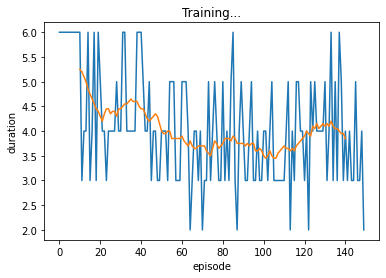

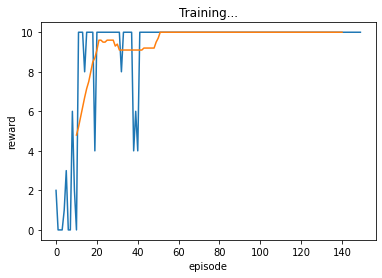

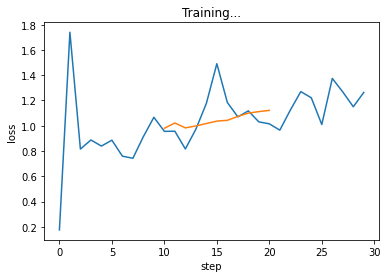

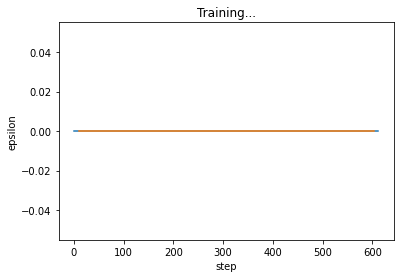

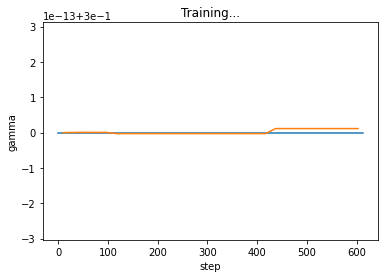

In [20]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.3, 0.3, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.6  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([0.8]), array([0.]), array([0]), array([0.8]), array([0.]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 d

reward 4.0 done False 
------guess 1 12743 guise [1.         0.6        0.63738935 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12901 pulse [0.5        0.4        0.63699925 0.         0.        ]-------
reward 0 done False 
------guess 3 11309 chase [0.33333333 0.4        0.69332333 0.         0.        ]-------
reward 0 done False 
------guess 4 12646 noise [0.5        0.2        0.73446362 0.         0.        ]-------
reward 0 done False 
------guess 5 12901 pulse [0.6        0.         0.63699925 0.         0.        ]-------
reward 0 done True 
episode 19 finished.  reward [6.]  eps 0.0  gamma 0.6  steps 102  memory 96
original rewards [array([4.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([2.8]), array([0.8]), array([0]), array([0]), array([0]), array([0])]
loss 1.1905369758605957
=========================episode 20 hippo======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.    

reward 2.0 done False 
------guess 1 5219 liter [1.         0.6        0.63750938 0.         1.        ]-------
reward 2.0 done False 
------guess 2 6274 nuder [1.         0.6        0.56222056 0.         1.        ]-------
reward 1.0 done False 
------guess 3 2659 edger [1.         0.2        0.64753188 0.33333333 1.        ]-------
reward 0 done False 
------guess 4 2045 cyder [0.75       0.4        0.52138035 0.         1.        ]-------
reward 1.0 done False 
------guess 5 2715 emeer [0.4        0.2        0.78379595 0.66666667 1.        ]-------
reward 0 done True 
episode 30 finished.  reward [6.]  eps 0.0  gamma 0.6  steps 151  memory 145
original rewards [array([2.]), array([2.]), array([1.]), array([0]), array([1.]), array([0])]
hybrid rewards [array([0.8]), array([0.8]), array([0.]), array([0]), array([0.]), array([0])]
=========================episode 31 abode======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward 4.0

reward 6.0 done False 
------guess 4 12695 slyly [0.5        0.4        0.5267817  0.66666667 0.        ]-------
reward 0 done False 
------guess 5 12214 humus [1.         0.2        0.4628057  0.33333333 0.        ]-------
reward 3.0 done True 
episode 39 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 197  memory 191
original rewards [array([1.]), array([0]), array([0]), array([6.]), array([0]), array([3.])]
hybrid rewards [array([1.]), array([0]), array([0]), array([6.]), array([0]), array([3.])]
=========================episode 40 mauve======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 1 11855 aware [1.         0.6        0.71534884 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 2 12824 latte [1.         0.4        0.67855964 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 3 11994 cache [1.         0.4        0.55417854 0.33333333 0.        ]-------

reward 1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12736 leech [1.         0.4        0.61464366 0.33333333 0.        ]-------
reward 2.0 done False 
------guess 3 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 6.0 done True 
episode 50 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 245  memory 241
original rewards [array([1.]), array([1.]), array([2.]), array([6.])]
hybrid rewards [array([2.2]), array([2.2]), array([3.2]), array([7.2])]
loss 1.1017831563949585
=========================episode 51 baggy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 0 done False 
------guess 2 12897 mangy [1.        0.8       0.4391898 0.        0.       ]-------
reward 5.0 done False 
----

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12840 punch [1.         0.6        0.33818455 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12475 funky [1.        0.6       0.3047862 0.        0.       ]-------
reward 6.0 done True 
episode 62 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 291  memory 287
original rewards [array([0]), array([2.]), array([2.]), array([6.])]
hybrid rewards [array([1]), array([3.2]), array([3.2]), array([7.2])]
=========================episode 63 humus======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 11271 spilt [1.         0.8        0.57341335 0.         0.        ]-------
reward 0 done False 
------guess 2 12392 dusky [1.         0.8        0.45635409 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12590 mucus [1.    

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 0 done False 
------guess 2 12897 mangy [1.        0.8       0.4391898 0.        0.       ]-------
reward 2.0 done False 
------guess 3 12860 fauna [1.         0.4        0.55687922 0.33333333 0.        ]-------
reward 7.0 done True 
episode 74 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 335  memory 331
original rewards [array([1.]), array([0]), array([2.]), array([7.])]
hybrid rewards [array([2.2]), array([1]), array([3.2]), array([8.2])]
loss 0.9753080606460571
=========================episode 75 dairy======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 10895 ultra [1.         0.6        0.57989497 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12343 cairn [1.         0.6        0.56675169 0.         0.        ]-------
reward 3.0 done False 
------g

reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12052 haunt [1.         0.6        0.49536384 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12300 tacky [0.66666667 0.6        0.44687172 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11962 patsy [0.75       0.2        0.60144036 0.         0.        ]-------
reward 1.0 done False 
------guess 5 11507 matey [0.8        0.2        0.60006002 0.         0.        ]-------
reward 0 done True 
episode 85 finished.  reward [6.]  eps 0.0  gamma 0.6  steps 383  memory 377
original rewards [array([1.]), array([1.]), array([1.]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([0.]), array([0.]), array([0.]), array([0.8]), array([0.]), array([0])]
=========================episode 86 boost======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------


reward 2.0 done False 
------guess 1 12799 antic [1.         0.8        0.54085521 0.         0.        ]-------
reward 0 done False 
------guess 2 11004 album [1.         0.8        0.46436609 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11850 apply [1.         0.4        0.46430608 0.33333333 0.        ]-------
reward 7.0 done True 
episode 97 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 427  memory 423
original rewards [array([2.]), array([0]), array([1.]), array([7.])]
hybrid rewards [array([3.2]), array([1]), array([2.2]), array([8.2])]
loss 1.4771380424499512
=========================episode 98 after======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 12165 alter [1.         0.4        0.70445611 0.         0.        ]-------
reward 4.0 done False 
------guess 2 12031 after [1.         0.2        0.63675919 0.         0.        ]-------
reward 2.0 done True 
epi

reward 1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11462 edict [1.         0.4        0.54604651 0.         0.        ]-------
reward 6.0 done True 
episode 109 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 471  memory 468
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([2.8]), array([4.8]), array([7.8])]
=========================episode 110 afoul======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 11182 aloud [1.         0.6        0.56303076 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11901 afoul [1.         0.2        0.52288072 0.         0.        ]-------
reward 3.0 done True 
episode 110 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 474  memory 471
original rewards [array([4.]), array([3.]), array([3.])]
hybrid rewards [array([5

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11476 dying [1.         0.6        0.38655664 0.         0.        ]-------
reward 3.0 done False 
------guess 3 12189 whiny [1.        0.4       0.3476069 0.        0.       ]-------
reward 5.0 done True 
episode 121 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 517  memory 513
original rewards [array([0]), array([2.]), array([3.]), array([5.])]
hybrid rewards [array([1]), array([3.2]), array([4.2]), array([6.2])]
=========================episode 122 urine======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
------guess 1 12091 urine [1.         0.6        0.60141035 0.         0.        ]-------
reward 6.0 done True 
episode 122 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 519  memory 517
original rewards [array([4.]), array([6.])]
hybrid rewards [arra

reward 2.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0.        0.       ]-------
reward 2.0 done True 
episode 133 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 560  memory 555
original rewards [array([2.]), array([2.]), array([2.]), array([2.]), array([2.])]
hybrid rewards [array([2.6]), array([2.6]), array([2.6]), array([2.6]), array([2.6])]
loss 1.3184187412261963
=========================episode 134 nasal======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.68228057 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12771 nasal [1.         0.         0.74922731 0.33333333 0.        ]-------
reward 5.0 done True 
episode 134 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 563  memory 560
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([3.8]), array([4.8]), array([6.8])]
======

reward 2.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 4.0 done False 
------guess 2 11858 timer [1.         0.4        0.59564891 0.         0.        ]-------
reward 0 done False 
------guess 3 12024 cider [1.         0.4        0.57194299 0.         0.        ]-------
reward 0 done False 
------guess 4 11434 fiber [1.         0.4        0.51975994 0.         0.        ]-------
reward 4.0 done True 
episode 145 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 608  memory 603
original rewards [array([2.]), array([4.]), array([0]), array([0]), array([4.])]
hybrid rewards [array([2.6]), array([4.6]), array([0]), array([0]), array([4.6])]
=========================episode 146 urban======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 12093 trial [1.         0.6        0.61734434 0.         0.        ]-------
reward 1.0 done False 
------g

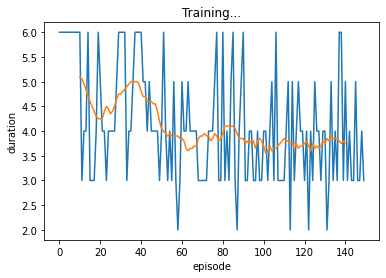

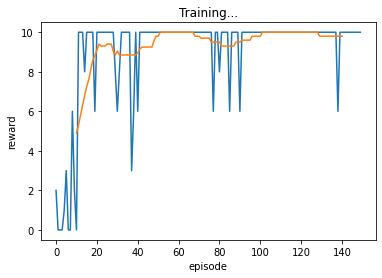

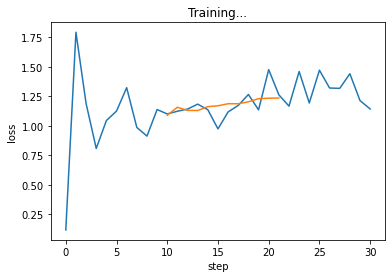

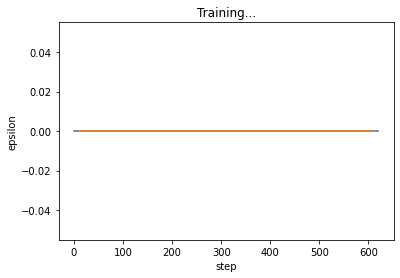

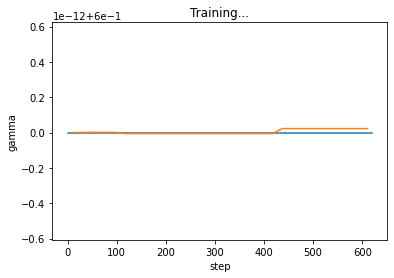

In [21]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.6, 0.6, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))